# ROC-curves

Python script for illustrating ROC curves with Gaussian examples.

For more information, see e.g. the Wikipedia page on __[ROC curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)__. 


### Authors: 
- Christian Michelsen (Niels Bohr Institute)
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 07-12-2023 (latest update)

***

In [3]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at

Then set up variables for the program:

In [4]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

save_plots = True        # For now, don't save plots (once you trust your code, switch on)
N_entries  = 1_000_000    # Notice that Python (3) allows us to write undercores in numeric values without it changing the value. 
                          # Useful as a 1000 separater, in phone numbers or similar cases.

## Variables in the calculation of ROC-curves:

For the computation of the ROC-curve, we rely heavily on the the Wikipedia page for __[ROC curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)__ and especially the following figure:

<img src="ROC_curves.png" height="500" />

In the figure above, <span style="color:red"> red is signal </span> and <span style="color:blue">blue is background </span>. We have the following variables:

- True Positives (__TP__, signal, power):  <span style="color:red"> strong red in figure </span>
- True Negatives (__TN__, background): <span style="color:blue"> strong blue in the figure </span>
- False Positives (__FP__, type 1 error):  <span style="color:IndianRed"> light red in figure </span>
- False Negatives (__FN__, type 2 error): <span style="color:MediumSlateBlue"> light blue in figure </span>

The __TPR__ is the ratio between TP and all true positives (TP, FN): $\text{TPR}=\frac{\text{TP}}{\text{TP} + \text{FN}}$.

The __FPR__ is the ratio between FP and all true negatives (FP, TN): $\text{FPR}=\frac{\text{FP}}{\text{FP} + \text{TN}}$.

The idea is that we move the cut (the vertical line, also known as threshold) from left to right and along the way measure the TPR and FPR as a function of the cut. Below we have made a function that, given two histograms, calculates the TPR and FPR as described: 

In [5]:
# Calculate ROC curve from two histograms (hist1 is signal, hist2 is background):
def calc_ROC(hist1, hist2) :

    # First we extract the entries (y values) and the edges of the histograms:
    # Note how the "_" is simply used for the rest of what e.g. "hist1" returns (not really of our interest)
    y_sig, x_sig_edges, _ = hist1 
    y_bkg, x_bkg_edges, _ = hist2
    
    # Check that the two histograms have the same x edges:
    if np.array_equal(x_sig_edges, x_bkg_edges) :
        
        # Extract the center positions (x values) of the bins (both signal or background works - equal binning)
        x_centers = 0.5*(x_sig_edges[1:] + x_sig_edges[:-1])
        
        # Calculate the integral (sum) of the signal and background:
        integral_sig = y_sig.sum()
        integral_bkg = y_bkg.sum()
    
        # Initialize empty arrays for the True Positive Rate (TPR) and the False Positive Rate (FPR):
        TPR = np.zeros_like(y_sig) # True positive rate (sensitivity)
        FPR = np.zeros_like(y_sig) # False positive rate ()
        
        # Loop over all bins (x_centers) of the histograms and calculate TN, FP, FN, TP, FPR, and TPR for each bin:
        for i, x in enumerate(x_centers): 
            
            # The cut mask
            cut = (x_centers < x)
            
            # True positive
            TP = np.sum(y_sig[~cut]) / integral_sig    # True positives
            FN = np.sum(y_sig[cut]) / integral_sig     # False negatives
            TPR[i] = TP / (TP + FN)                    # True positive rate
            
            # True negative
            TN = np.sum(y_bkg[cut]) / integral_bkg      # True negatives (background)
            FP = np.sum(y_bkg[~cut]) / integral_bkg     # False positives
            FPR[i] = FP / (FP + TN)                     # False positive rate            
            
        return FPR, TPR
    
    else:
        AssertionError("Signal and Background histograms have different bins and/or ranges")

## Gaussian distributions (signal & background) of varying separation:

Now we generate the data that we are going to use. We want to generate data for signal and a background (both Gaussian) that are shifted unit Gaussians (i.e. mean different from 0) such that their separation is $N_\sigma = $ `N_sigma`:

In [6]:
N_sigma = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 3.0])      # We choose six signal-background separations

Based on the above, define the means and widths of the signal and background Gaussians: We choose the widths to be unit, and the means to move symmetrically around $5.0$ (arbitrary choice):
$$N_\sigma = \frac{\mu_s - \mu_b}{\sqrt{ {\sigma_s}^2+{\sigma_b}^2 }} =  \frac{\Delta_\mu}{\sqrt 2}$$

Which in code looks like:


In [7]:
mean_sig = 5 + N_sigma / np.sqrt(2.0)
mean_bkg = 5 - N_sigma / np.sqrt(2.0)

Having defined the means, we can now generate the random Gaussianly distributed numbers:

In [8]:
random_sig = r.normal(loc=mean_sig, scale=1, size=(N_entries, len(N_sigma)))
random_bkg = r.normal(loc=mean_bkg, scale=1, size=(N_entries, len(N_sigma)))

## Plot the data:

Before we plot the data, we set up the figure consisting of 6 smaller plots (one for each value in `N_sigma`) and a large plot to show the ROC-curve:

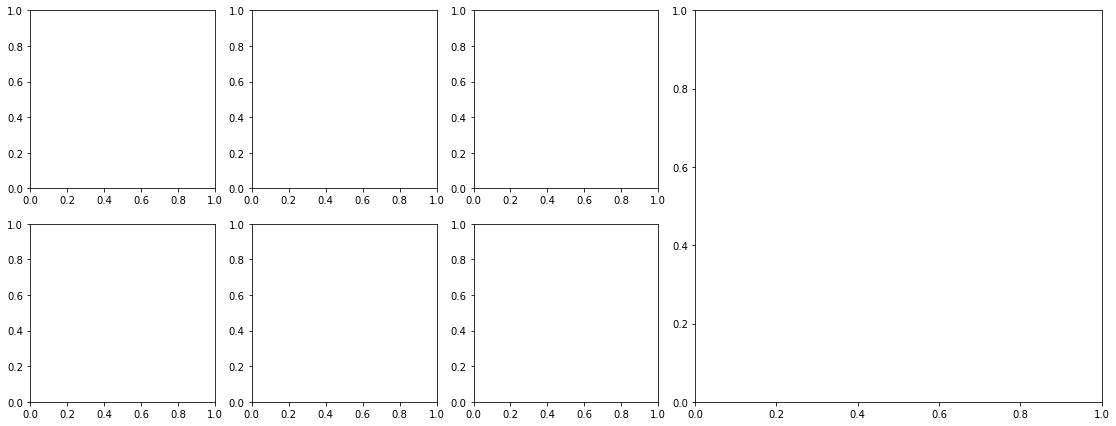

In [9]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(16*1.2,6*1.2))

gs = GridSpec(2,5) # 2 rows, 3 columns
ax = [fig.add_subplot(gs[0,0]), # First row,   first column
      fig.add_subplot(gs[1,0]), # Second row,  first column
      fig.add_subplot(gs[0,1]), # First row,   second column
      fig.add_subplot(gs[1,1]), # Second row,  second column
      fig.add_subplot(gs[0,2]), # First row,  third column
      fig.add_subplot(gs[1,2])] # Second row,  third column
ax2 = fig.add_subplot(gs[:,3:]) # Span both rows and columns from 3 and onwards

Now we loop over all our data (`random_sig` and `random_bkg`) and plot it as histograms in the 6 small subplots:

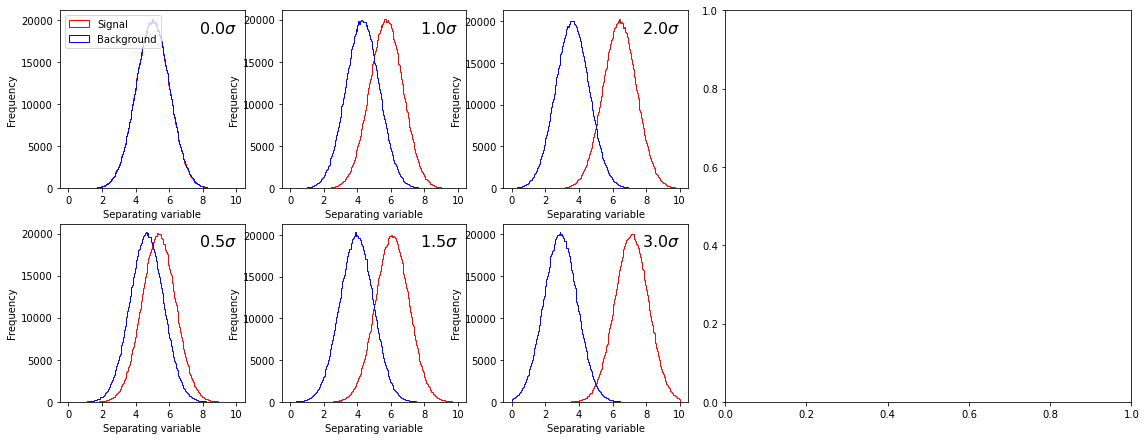

In [10]:
N_bins = 200
xmin, xmax = 0, 10

hist_sig = []
hist_bkg = []

y_sig = np.zeros((N_bins, len(N_sigma)))
y_bkg = np.zeros_like(y_sig)

for i in range(len(N_sigma)):
    hist_sig.append(ax[i].hist(random_sig[:, i], bins=N_bins, range=(xmin, xmax), histtype='step', lw=1, label='Signal', color='red'))
    hist_bkg.append(ax[i].hist(random_bkg[:, i], bins=N_bins, range=(xmin, xmax), histtype='step', lw=1, label='Background', color='blue'))
    ax[i].set_xlabel('Separating variable')
    ax[i].set_ylabel('Frequency')
    ax[i].text(0.75, 0.9, r'{:1.1f}$\sigma$'.format(N_sigma[i]), size=16,
              verticalalignment='center', transform=ax[i].transAxes)

ax[0].legend(loc='upper left')
fig

Having plotted the input distributions, we can now focus on the actual ROC-curves. We loop over all the histograms and calculate the FPR and TPR and plot it along with small text annotations describing the number of $\sigma$ of separation: 

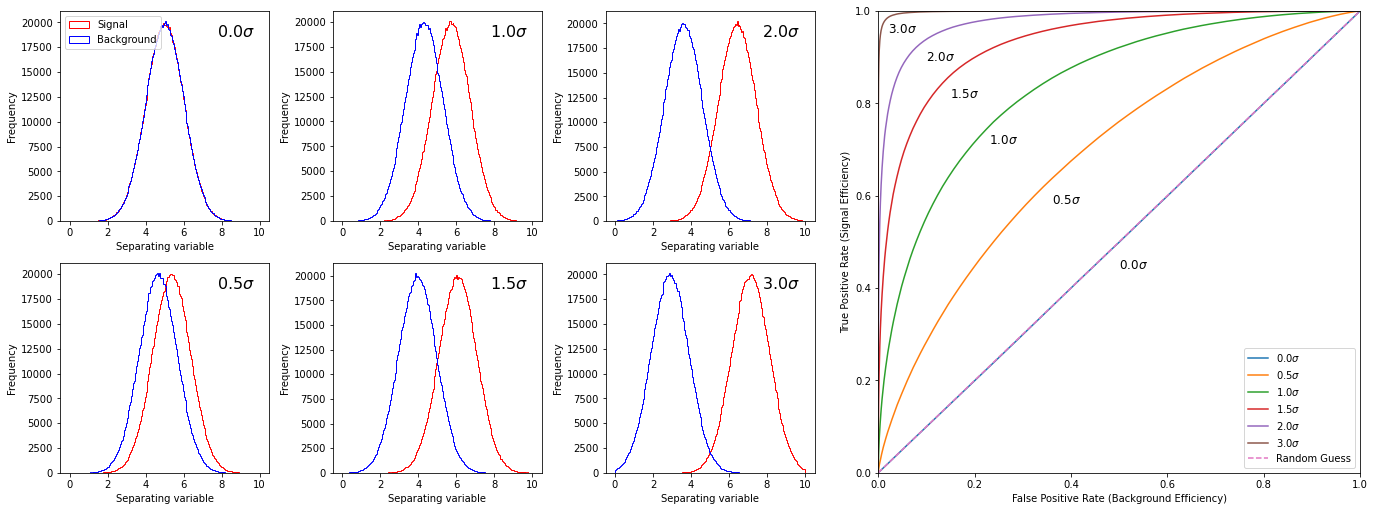

In [11]:
# Locations of the text placement on plot:
text_sigma_loc = [(0.5, 0.45), (0.36, 0.59), (0.23, 0.72), (0.15, 0.82), (0.1, 0.9), (0.02, 0.96)]

# Dictionary to save the FPRs and TPRs:
d = {}

for i in range(len(N_sigma)) :
    
    # Number of sigmas written as string ('r' to make it a raw string literal, i.e. allows LaTeX-style):
    text_sigma = fr'{N_sigma[i]:1.1f}$\sigma$'
    
    # Calculate FPR and TPR by calc_ROC:
    FPR, TPR = calc_ROC(hist_sig[i], hist_bkg[i])    
    d[int(N_sigma[i]*10)] = {'FPR': FPR, 'TPR': TPR}
    
    # Plot the roc-curve:
    ax2.plot(FPR, TPR, '-', label=text_sigma)
    
    # Add text:
    ax2.text(text_sigma_loc[i][0], text_sigma_loc[i][1], text_sigma, size=12, verticalalignment='center', transform=ax2.transAxes)
    

# Plot diagonal line:
ax2.plot([0, 1], [0, 1], '--', label='Random Guess')

# Set figure options:
ax2.set(xlabel='False Positive Rate (Background Efficiency)', ylabel='True Positive Rate (Signal Efficiency)', xlim=(0, 1), ylim=(0, 1))
ax2.legend()

fig.tight_layout()
fig

Save the plots:

In [ ]:
if save_plots:
    fig.savefig('ROCcurves_GaussianSeparations.pdf', dpi=600)

## Simple alternative:

Scikit-learn is a package for Machine Learning (ML), and Scikit-plot is package for plotting in relation to ML. Therefore, it has a build-in ROC curve plotting tool, which is shown below. It requires two arrays, one with the true labels (which we often denote "y" or "y_true"), that is the target of the learning (i.e. typically two cases: 0 and 1), and one with the predictions of an (ML-) algorithm ("y_hat" or "y_predict"), which are floating numbers attempted - for the two cases - to be as separated from each other, as possible.

In [ ]:
# import scikitplot as skplt
# 
# y_true = # ground truth labels
# y_probas = # predicted probabilities generated by sklearn classifier
# skplt.metrics.plot_roc_curve(y_true, y_probas)
# plt.show()

***

Below we show how to save files using Pickle. This is saved as a binary file and then read in again:

In [ ]:
import pickle

filename = f'ROC_curve_FPR_TPR_N_{N_entries}.pkl'

with open(filename, 'wb') as outfile:
    pickle.dump(d, outfile)

with open(filename, 'rb') as infile:
    d_new = pickle.load(infile)

# "Question"
- Make sure that you understand what the ROC represents, and how it is calculated!